# <div align="center">Data Science with Stock Data - Change of Trend Detection</div>
### <div align="center">Author: <a href="https://www.linkedin.com/in/kaming-yip-22b03a1a0/">Kaming Yip</a>&emsp;&emsp;Date: Mar. 23, 2020</div>

Before start reading this file, you are suggested to read the project instruction in the <a href="https://github.com/KamingYip/Data-Science-with-Stock-Data/blob/master/README.md">README.md</a> file.

In this file, we will apply <i>F</i>-test to detect whether there is a (statistically) significant change in the pricing behavior of the selected stock within some time interval. <i>F</i>-tests are often used to test equivalence of models that have been fitted to data using the least squares (such as linear regression). Some examples include
  
  * testing whether regression fits the data well
  * testing for equality of means of normally distributed populations
  * testing whether two regression lines fits data better than one column

We will focus on the last item here.

To start with, we scrape the historical data from <a href="https://finance.yahoo.com/quote/YELP?p=YELP&.tsrc=fin-srch-v1">yahoo web</a> and manipulate the data to create desirable columns.

In [1]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np

In [2]:
def get_stock(ticker, start_date, end_date):
    try:
        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Return'] = 100.0 * df['Return']
        df['Return'] = df['Return'].round(3)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.weekday_name  
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 'Week_Number', 'Year_Week',
                    'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Return']
        df = df[col_list]
        return df
    except Exception as error:
        print(error)
        return None

ticker='YELP'
df = get_stock(ticker, start_date='2018-01-01', end_date='2019-12-31')
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return
Date,,,,,,,,,,,,,,
2018-01-02,2018-01-02,2018,1,2,Tuesday,00,2018-00,42.06,43.47,42.06,43.24,1355300,43.24,0.000
2018-01-03,2018-01-03,2018,1,3,Wednesday,00,2018-00,43.35,43.59,42.86,43.12,1347700,43.12,-0.278
2018-01-04,2018-01-04,2018,1,4,Thursday,00,2018-00,43.36,43.53,42.52,42.82,933000,42.82,-0.696
2018-01-05,2018-01-05,2018,1,5,Friday,00,2018-00,42.95,43.34,42.74,43.17,916700,43.17,0.817
2018-01-08,2018-01-08,2018,1,8,Monday,01,2018-01,43.03,43.89,42.72,43.67,807600,43.67,1.158


By far, we have completed the data preparation. From the raw data, we have conducted feature engineering to create new features that we would use in the modeling.

Next step we will establish the <i>F</i>-test model. Especially, for each time period <i>T</i> (e.g. month), we want to check if there is a (statistically) significant change in pricing pattern for the selected stock. We proceed as follows. Assume that the time period contains <i>n</i> days and let <i>P</i><sub>1</sub> , ... , <i>P</i><sub>n</sub> denote the (adjusted closing) prices for days <i>i</i> = 1, ... , <i>n</i> . We construct a simple linear regression model for the price <i>P<sub>i</sub></i> = <i>α</i> * <i>i</i> + <i>β</i> . This model has two unknown parameters: slope <i>α</i> and intercept <i>β</i> . Therefore, for this model, the number of degrees of freedom <i>d</i> = 2. In general, if we have a linear regression on <i>m</i> variables, we would need to compute <i>m</i> slope coefficients and intercept - in this case <i>d</i> = <i>m</i> + 1. Let SSE(<i>T</i>) denote the sum of the squared residuals ("loss" function) for the regression line that "fits" prices <i>P</i><sub>1</sub> , ... , <i>P</i><sub>n</sub> .

Then, we look for a day 1 < <i>k</i> < n where we suspect there is a change in linear trend. To find such a day, we divide our period <i>T</i> into two time periods: <i>T</i><sub>1</sub> containing days 1, ... , <i>k</i> and <i>T</i><sub>2</sub> containing days <i>k</i> + 1, ... , n. Within each period, we construct two regressions and compute the corresponding loss functions SSE(<i>T</i><sub>1</sub>) and SSE(<i>T</i><sub>2</sub>). We look for <i>k</i> that minimizes the total loss from using two regressions SSE(<i>T</i><sub>1</sub>) + SSE(<i>T</i><sub>2</sub>). Note that for each regression, the number of degrees of freedom is <i>d</i><sub>1</sub> = 2 and <i>d</i><sub>2</sub> = 2.

Once we computed our "break" day candidate k, we construct the following <i>F</i> statistics. To simply the notation, let us define <i>L</i> = SSE(<i>T</i>), <i>L</i><sub>1</sub> = SSE(<i>T</i><sub>1</sub>) and <i>L</i><sub>2</sub> = SSE(<i>T</i><sub>2</sub>). Our <i>F</i> statistics is then

<a href="https://www.codecogs.com/eqnedit.php?latex=F&space;=&space;[\frac{L&space;-&space;(L_{1}&space;&plus;&space;L_{2})}{d_{1}&space;&plus;&space;d_{2}&space;-&space;d}]&space;\cdot&space;[\frac{L_{1}&space;&plus;&space;L_{2}}{n&space;-&space;(d_{1}&space;&plus;&space;d_{2})}]^{-1}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?F&space;=&space;[\frac{L&space;-&space;(L_{1}&space;&plus;&space;L_{2})}{d_{1}&space;&plus;&space;d_{2}&space;-&space;d}]&space;\cdot&space;[\frac{L_{1}&space;&plus;&space;L_{2}}{n&space;-&space;(d_{1}&space;&plus;&space;d_{2})}]^{-1}" title="F = [\frac{L - (L_{1} + L_{2})}{d_{1} + d_{2} - d}] \cdot [\frac{L_{1} + L_{2}}{n - (d_{1} + d_{2})}]^{-1}" /></a>

<a href="https://www.codecogs.com/eqnedit.php?latex==&space;[\frac{L&space;-&space;(L_{1}&space;&plus;&space;L_{2})}{2}]\cdot&space;[\frac{L_{1}&space;&plus;&space;L_{2}}{n&space;-&space;4}]^{-1}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?=&space;[\frac{L&space;-&space;(L_{1}&space;&plus;&space;L_{2})}{2}]\cdot&space;[\frac{L_{1}&space;&plus;&space;L_{2}}{n&space;-&space;4}]^{-1}" title="= [\frac{L - (L_{1} + L_{2})}{2}]\cdot [\frac{L_{1} + L_{2}}{n - 4}]^{-1}" /></a>

Under the null hypothesis that two regression lines do not provide a significantly better fit than one regression line, <i>F</i> will have an (Fisher) <i>F</i>-distribution with (2, <i>n</i> - 4) degrees of freedom. The null hypothesis is rejected if the <i>F</i> is greater than some critical value. In this case, we will use 0.05 as critical value.

In [3]:
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from scipy.stats import f as fisher_f

In [4]:
def linear_regression(x, y):
    lin_reg = LinearRegression(fit_intercept = True)
    lin_reg.fit(x, y)
    y_pred = lin_reg.predict(x)
    L = ((y - y_pred) ** 2).sum()
    return L

def F_test(data, year, alpha):
    results = pd.DataFrame(columns = ["Year", "Month", "Candidate k", "F Stats",
                                      "F Value", "p value", "Null Hypethesis"])
    
    for month in range(1, 13):
        monthly_data = data[data["Month"] == month].copy()
        X = pd.Series(range(1, len(monthly_data)+1))
        X_2 = X[:, np.newaxis]
        y = monthly_data["Adj Close"].values
        
        # 'loss' function: SSE(T)
        L = linear_regression(X_2, y)
        
        k_results = pd.DataFrame(columns = ["k", "L1", "L2", "L1+L2"])
        # divide into two time periods
        for k in range(2, len(monthly_data)):
            # period T1
            T1 = monthly_data.iloc[ : k]
            X_1 = pd.Series(range(1, k+1))
            X_1_2 = X_1[: , np.newaxis]
            y_1 = T1["Adj Close"].values
            L1 = linear_regression(X_1_2, y_1)
            
            # period T2
            T2 = monthly_data.iloc[k : ]
            X_2 = pd.Series(range(k+1, len(monthly_data)+1))
            X_2_2 = X_2[: , np.newaxis]
            y_2 = T2["Adj Close"].values
            L2 = linear_regression(X_2_2, y_2)
            
            k_results = k_results.append({"k": k, "L1": L1, "L2": L2, "L1+L2": L1+L2},
                                         ignore_index = True)
        
        optimal_k = k_results.loc[k_results["L1+L2"].idxmin(), "k"]
        min_sum = k_results["L1+L2"].min()
        F = ((L - min_sum) / 2) * ((min_sum / (len(monthly_data) - 4)) ** (-1))
        F_value = fisher_f.ppf(q = 1 - alpha, dfn = 2, dfd = len(monthly_data) - 4)
        p_value = fisher_f.sf(F, 2, len(monthly_data) - 4)
        
        results = results.append({"Year": year, "Month": month, "Candidate k": optimal_k,
                                  "F Stats": F, "F Value": F_value, "p value": p_value,
                                  "Null Hypethesis": ("Reject" if p_value < alpha else "Accept")},
                                 ignore_index = True)
        
    return results

In [5]:
alpha = 0.05
df_2018 = df.loc[df["Year"] == 2018].copy().reset_index(drop = True)
df_2018_results = F_test(df_2018, 2018, alpha)
print(" " * 35 + "* Year 2018 *" + "\n\n",
      tabulate(df_2018_results, headers = "keys", numalign = "right", stralign = "right",
               floatfmt = (None, None, None, ".0f", ".3f", ".3f", ".5f")))

                                   * Year 2018 *

       Year    Month    Candidate k    F Stats    F Value    p value    Null Hypethesis
--  ------  -------  -------------  ---------  ---------  ---------  -----------------
 0    2018        1             11      4.762      3.592    0.02280             Reject
 1    2018        2              5     55.169      3.682    0.00000             Reject
 2    2018        3              9     51.566      3.592    0.00000             Reject
 3    2018        4             13     24.094      3.592    0.00001             Reject
 4    2018        5              8      8.837      3.555    0.00212             Reject
 5    2018        6             11      7.069      3.592    0.00583             Reject
 6    2018        7             12     10.411      3.592    0.00112             Reject
 7    2018        8              6     54.127      3.522    0.00000             Reject
 8    2018        9             10     16.431      3.682    0.00017            

In [6]:
df_2019 = df.loc[df["Year"] == 2019].copy().reset_index(drop = True)
df_2019_results = F_test(df_2019, 2019, alpha)
print(" " * 35 + "* Year 2019 *" + "\n\n",
      tabulate(df_2019_results, headers = "keys", numalign = "right", stralign = "right",
               floatfmt = (None, None, None, ".0f", ".3f", ".3f", ".5f")))

                                   * Year 2019 *

       Year    Month    Candidate k    F Stats    F Value    p value    Null Hypethesis
--  ------  -------  -------------  ---------  ---------  ---------  -----------------
 0    2019        1              6      3.336      3.592    0.05996             Accept
 1    2019        2             10     15.060      3.682    0.00026             Reject
 2    2019        3              4     29.208      3.592    0.00000             Reject
 3    2019        4             14     88.166      3.592    0.00000             Reject
 4    2019        5              7    123.664      3.555    0.00000             Reject
 5    2019        6              2      3.795      3.634    0.04479             Reject
 6    2019        7             11     17.600      3.555    0.00006             Reject
 7    2019        8              9      8.720      3.555    0.00225             Reject
 8    2019        9              7     47.948      3.634    0.00000            

When we compare the <i>p value</i> for the <i>F</i>-test to the significance level (i.e. 0.05 in this instance), it is computed that the <i>p value</i> of each month is always less than the alpha level except for January 2019. As we have discussed above, if the <i>p value</i> is less than the significance level, we will reject the null hypothesis and the data provides sufficient evidence to conclude that two regression lines will fit the data better than the one regression line. On the other hand, in January 2019, the <i>p value</i> (i.e. 0.05996) is higher than our assigned significance level, which indicates that we are not 95% confident to reject the null; in other words, we should accept the null hypothesis under this setting and the data suggests that two regression lines do not provide a significantly better fit than one regression line.

In [7]:
import matplotlib.pyplot as plt
import calendar

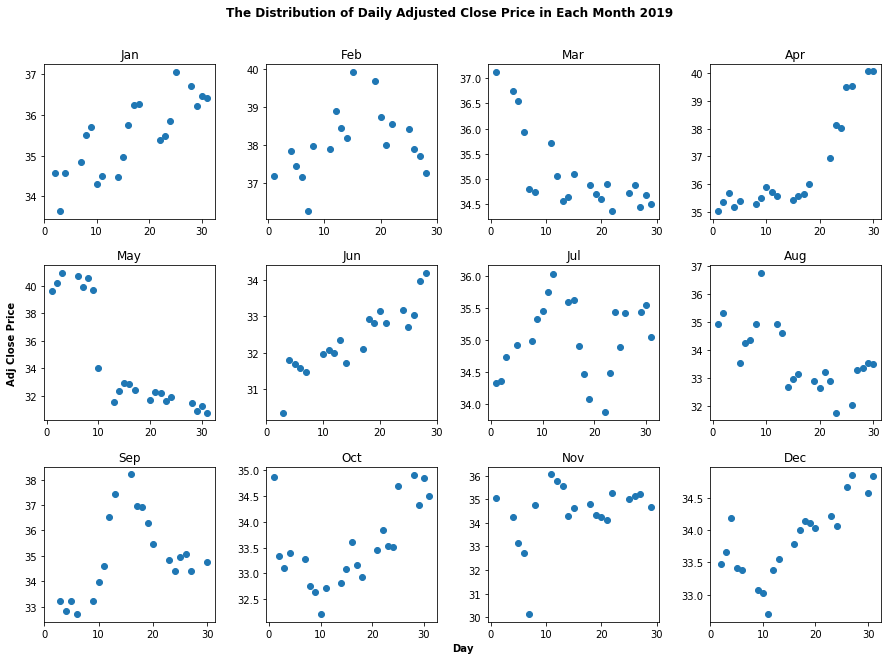

In [8]:
rows = 3
cols = 4

fig = plt.figure(figsize = (15, 10))
axes = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", top = False, bottom = False, left = False, right = False)
fig.subplots_adjust(hspace = 0.3, wspace = 0.3, top = 0.90)
for i in range(1, 13):
    ax = fig.add_subplot(rows, cols, i)
    ax.scatter(df_2019.loc[df_2019["Month"] == i, "Day"], df_2019.loc[df_2019["Month"] == i, "Adj Close"])
    ax.set_title(calendar.month_abbr[i])
    ax.set_xticks(np.arange(0, 35, 10))

fig.suptitle("The Distribution of Daily Adjusted Close Price in Each Month 2019", fontweight = "bold")
axes.set_xlabel("Day", fontweight = "bold")
axes.set_ylabel("Adj Close Price", fontweight = "bold")
plt.show() 

The scatter plots display how the adjusted closing price distributes in each month in year 2019. By visualizing the distribution, we can confirm that the stock (adjusted closing) price in January generally increased as time went by, following a linear distribution, while the data points in other months were more dispersive and could hardly be summarized with a single regression line. The visualization clearly demonstrates the patterns among the price, which makes the <i>F</i>-test results more convincing.